In [1]:
from AttentionModule import Conv2d_Attn

import torch
from torch import nn
from torchvision import models, datasets, transforms
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import os
import re
import numpy as np

In [2]:
resnet_pretrained = models.resnet50(pretrained=True)
nn.Conv2d = Conv2d_Attn
resnet_attn = models.resnet50()
resnet_attn.load_state_dict(resnet_pretrained.state_dict(), strict=False)

In [3]:
# This block turns 'layer1.0.downsample.0.weight' to 'layer1[0].downsample[0].weight'
param_keys = list(resnet_attn.state_dict().keys())
formatted_keys = []
for k in param_keys:
    found = re.findall(r'\.[\d]{1,2}\.', k)
    if len(found):
        for f in found:
            k = k.replace(f, '[{}].'.format(f.strip('.')))
    formatted_keys.append(k)

In [4]:
# This block turn off gradient up for all params except attn_weights
def turn_off_grad_except(lst=[]):
    for k in formatted_keys:
        obj = eval('resnet_attn.'+k)
        for kw in lst:
            if not kw in k:
                obj.requires_grad = False
            else:
                obj.requires_grad = True

In [5]:
resnet_attn.fc = nn.Linear(resnet_attn.fc.in_features, 144)

Start training

In [6]:
batch_size = 32

# count number of instances for each class and use sampler for class imbalance
TRAIN_DIR = '/home/bdrad1/ryan/194/data/train'
VAL_DIR = '/home/bdrad1/ryan/194/data/val'
TEST_DIR = '/home/bdrad1/ryan/194/data/test'

classes = os.listdir(TRAIN_DIR)
classes.remove('.DS_Store')
class_counts = [len(os.listdir(os.path.join(TRAIN_DIR, c))) for c in classes]

c = 0
weights = []
for directory, _, files in os.walk(TRAIN_DIR):
    if not directory.endswith('train'):
        for f in files:
            weights.append(class_counts[c])       

weights = [1.0/i for i in weights]
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, 8161, replacement= True)

In [7]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform = transforms.Compose(
    [
        transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ])

trainset = torchvision.datasets.ImageFolder(root=TRAIN_DIR, transform=transform)
valset = torchvision.datasets.ImageFolder(root=VAL_DIR, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False, num_workers=2, sampler = sampler)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [8]:
total_imgs = len(trainset.imgs)
print('number of training images', total_imgs)

number of training images 8161


In [9]:
resnet_attn = resnet_attn.cuda()

In [10]:
total_attn_params = 0
for k in formatted_keys:
    obj = eval('resnet_attn.'+k)
    if 'attn_weights' in k:
        total_attn_params += np.prod(obj.shape)
print("Total number of attention parameters", total_attn_params)

Total number of attention parameters 13385920


We want the attention parameters to diverge from 1, therefore we penalize element-wise square loss as $\lambda (1 \times \text{# params} - (x - 1)^2)$

But this is too big a number,
let's try: 
$- (x - 1)^2$ for now

In [11]:
_lambda = 1e-2 #set default

In [12]:
def get_params_objs(name, net='resnet_attn'):
    res = []
    for k in formatted_keys:
        obj = eval(f'{net}.'+k)
        if name in k:
            res.append(obj)
    return res

In [13]:
def compute_attn_loss(n_params=26560):
    attns = get_params_objs('attn_weights')
    penality = sum([torch.pow(t - 1,2).mean() for t in attns])
    return _lambda*(- penality)

In [14]:
print_every = 5

In [15]:
def train_one_epoch(add_attn=True):
    cls_criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet_attn.parameters()))
    
    running_loss = 0.0
    running_attn_loss = 0.0
    running_corrects = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = Variable(inputs).cuda(), Variable(labels).cuda()
        
        optimizer.zero_grad()
        outputs = resnet_attn(inputs)
        

        loss = cls_criterion(outputs, labels)
        attn_loss = compute_attn_loss()
        if add_attn:
            loss += attn_loss
        
        loss.backward()
        optimizer.step()
        
        #calculate training acc
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels)
        
        running_loss += loss.data[0]
        running_attn_loss += attn_loss.data[0]
        
        if i % print_every == 0:
            print('[%5d] iter, [%2f] epoch, avg loss: %.3f, attn_loss: %.5f ' %
                  (i + 1, i*batch_size/total_imgs, running_loss/print_every, running_attn_loss/print_every))
            running_loss = 0.0
            running_attn_loss = 0.0
    training_acc = running_corrects.double() / total_imgs
    return training_acc, optimizer

In [16]:
from tqdm import tqdm
def score(net=resnet_attn, batch_size=batch_size):
    trainset = torchvision.datasets.ImageFolder(root=TRAIN_DIR, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2)
    
    valset = torchvision.datasets.ImageFolder(root=VAL_DIR, transform=transform)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                              shuffle=True, num_workers=2)
    
    train_correct = 0
    val_correct = 0
    
    for inp, label in tqdm(iter(trainloader)):
        _, idx = net(Variable(inp).cuda()).topk(3)
        train_correct += int(sum(idx.cpu().data == label))
    
    for inp, label in tqdm(iter(valloader)):
        _, idx = net(Variable(inp).cuda()).topk(3)
        val_correct += int(sum(idx.cpu().data == label))
    
    return {
        'train_accu': train_correct/len(trainset),
        'val_accu': val_correct/len(valset)
    }

Train a fresh fc layer. 
`turn_off_grad_except([])` turns off grads for all weights but the fc layer

In [23]:
turn_off_grad_except(['fc'])
resnet_attn.eval() # Turn on batchnorm
train_one_epoch(add_attn=False)

Variable containing:
  37
  65
  10
  88
  10
  82
   4
  57
  12
  89
 117
  82
  53
  81
  48
  31
  81
 130
  71
   3
  81
 137
  82
  81
  82
  14
  81
  31
 117
  31
  94
  53
[torch.cuda.LongTensor of size 32 (GPU 0)]
 labels
Variable containing:
 -8.8224  -5.5490 -11.0667  ...   -4.5050  -6.2044  -8.0272
 -6.5172  -4.9558  -7.7487  ...   -4.9208  -6.1230  -5.1686
 -8.1773  -6.5308  -9.8577  ...   -7.1756  -7.7570  -7.0593
           ...               ⋱              ...            
 -6.2425  -3.8046  -7.5695  ...   -4.2101  -5.5050  -6.4773
 -7.2900  -3.5332  -8.5206  ...   -2.9919  -4.7748  -5.1716
 -9.1651  -7.9062 -11.8456  ...   -3.8832  -6.5470  -7.3247
[torch.cuda.FloatTensor of size 32x144 (GPU 0)]
 outputs!
[    1] iter, [0.000000] epoch, avg loss: 0.525, attn_loss: 0.00000 
Variable containing:
  48
 143
 136
  52
  56
  89
  88
 117
  31
  36
 141
  84
  53
  89
 108
  80
  82
 119
  36
  81
  82
 137
  31
   3
  50
  86
  20
   7
  80
  80
  53
   7
[torch.cuda.LongTen

Variable containing:
-12.1551 -12.1455 -15.5434  ...   -4.3281 -12.7386  -7.4686
-13.9490 -16.3424 -17.6169  ...   -4.8032 -15.8916  -8.9550
-14.3348 -16.1759 -19.4663  ...   -7.1081 -17.4416  -9.4054
           ...               ⋱              ...            
-11.3085 -12.0702 -14.2539  ...   -6.2007 -11.2211  -6.5612
-10.6420 -13.9130 -15.1559  ...   -3.9137 -13.0476  -7.6723
-12.3241 -14.1782 -16.5817  ...   -6.1052 -13.9036  -7.6075
[torch.cuda.FloatTensor of size 32x144 (GPU 0)]
 outputs!
Variable containing:
  81
  53
  89
  81
  65
  71
 136
 123
  20
   6
  99
 115
  43
  86
 107
 141
  36
   7
 136
  50
   5
 130
 136
  80
  85
  48
  26
  29
   3
  81
   3
  95
[torch.cuda.LongTensor of size 32 (GPU 0)]
 labels
Variable containing:
-13.7826 -15.3946 -18.5592  ...   -7.3763 -16.4513  -8.8360
-11.9894 -16.9177 -18.0985  ...   -8.2591 -15.7432 -11.3284
-12.7775 -16.2137 -20.4497  ...   -7.0112 -15.2804  -9.7180
           ...               ⋱              ...            
-13.2794

Variable containing:
 -7.4994 -14.7115 -10.5578  ...   -7.3221 -14.0937  -9.4892
 -8.8937 -17.7655 -13.4024  ...  -10.0989 -18.0796 -10.6314
 -6.5902 -14.0290 -10.2160  ...   -9.9746 -15.2491 -11.2300
           ...               ⋱              ...            
 -8.9811 -18.7871 -13.5835  ...  -10.5771 -19.0401 -11.5243
 -8.2603 -17.3265 -12.5380  ...   -9.2977 -17.2500 -12.4376
 -9.1893 -16.2944 -13.0018  ...   -7.5337 -16.9724 -11.6864
[torch.cuda.FloatTensor of size 32x144 (GPU 0)]
 outputs!
Variable containing:
   8
 107
  20
  80
  20
 123
 130
 136
  31
   3
 114
  17
 132
 141
   3
 122
  53
 134
  89
  20
 122
  55
 141
   8
  10
 130
 136
  98
  81
   3
  89
   5
[torch.cuda.LongTensor of size 32 (GPU 0)]
 labels
Variable containing:
 -7.8658 -15.5638 -12.5966  ...   -9.6626 -16.6114 -11.2646
 -8.1721 -18.5659 -12.6973  ...  -10.0907 -18.2213 -13.0351
 -7.7466 -17.5903 -13.3455  ...  -10.0682 -18.0366 -14.2440
           ...               ⋱              ...            
 -7.7779

Variable containing:
 -8.8004 -16.4912  -9.6333  ...   -6.9319 -13.9408 -11.4493
-10.2847 -16.8769 -10.0775  ...  -10.0392 -13.6560 -11.7667
 -9.8529 -16.6082  -9.8016  ...   -2.9288 -12.7461 -11.7763
           ...               ⋱              ...            
 -8.6872 -20.4491 -10.8954  ...   -8.2291 -15.0386 -14.0629
 -7.1817  -9.5177  -4.1614  ...   -6.0223  -8.7471  -6.1393
 -8.8372 -18.8401 -11.7672  ...   -6.3215 -15.0904 -12.2204
[torch.cuda.FloatTensor of size 32x144 (GPU 0)]
 outputs!
Variable containing:
  81
  50
  12
  88
  89
   8
  65
  20
  43
  53
 136
 135
 117
 117
  52
 139
  36
  31
  20
  52
  10
  53
  89
  45
  82
  95
  95
 112
  97
 117
   8
  48
[torch.cuda.LongTensor of size 32 (GPU 0)]
 labels
Variable containing:
 -9.0031 -14.4674  -8.8868  ...   -6.2532 -11.6650  -8.9299
 -7.3076 -15.1507  -9.5260  ...   -7.5542 -10.3299 -10.8383
 -7.3462 -13.7094  -8.2056  ...  -10.3700 -13.0036 -11.6586
           ...               ⋱              ...            
 -9.8630

Variable containing:
-11.3393 -18.1576 -12.5531  ...   -6.9564 -10.6672 -10.8696
-12.2151 -18.5026 -11.1086  ...  -10.1630 -13.2863 -12.4564
 -8.8401 -15.0885  -9.7124  ...   -9.5564 -11.1695 -11.7738
           ...               ⋱              ...            
 -5.6051  -9.9592  -5.2582  ...   -4.6180  -6.9537  -7.1521
 -9.7988 -17.8158 -10.3979  ...   -7.9813 -10.5393 -11.6253
 -9.8474 -14.7074  -8.1851  ...   -7.1894 -10.8338 -10.9052
[torch.cuda.FloatTensor of size 32x144 (GPU 0)]
 outputs!
Variable containing:
 107
  53
  31
   7
 122
  53
  58
   7
  99
  81
  20
  37
 136
 141
 117
   3
  31
  57
 122
   3
 117
   4
  89
 111
   4
  46
 141
 108
 123
 117
   7
 130
[torch.cuda.LongTensor of size 32 (GPU 0)]
 labels
Variable containing:
-10.4978 -16.2669 -10.0040  ...   -6.5981 -10.0558  -8.4726
-10.4600 -16.9867 -10.9062  ...   -8.2217 -11.4621 -11.7740
 -7.6735 -14.4746  -8.0127  ...   -7.2618 -10.1058 -10.5958
           ...               ⋱              ...            
-11.2277

Variable containing:
-13.2826 -13.2212 -12.4570  ...   -9.9069 -11.9025 -11.7884
-11.1347 -10.5283  -8.4033  ...   -5.1743  -8.9553  -6.5232
-11.0777 -12.4810 -12.3212  ...   -9.7187 -11.2834 -11.1503
           ...               ⋱              ...            
-11.9983 -12.2301 -10.6581  ...   -9.8507 -11.7597 -11.3655
-14.2263 -13.9589 -12.8159  ...  -12.1064 -12.8807 -12.1324
-12.4560 -12.4852  -9.9711  ...   -7.1123  -9.9904  -7.1374
[torch.cuda.FloatTensor of size 32x144 (GPU 0)]
 outputs!
Variable containing:
  97
 130
  20
  82
  31
  82
  53
  43
  20
  81
  31
 114
  91
 117
  20
 136
  53
 129
  20
  53
 141
  39
  86
 139
  82
  77
  20
   3
 132
   3
  20
  88
[torch.cuda.LongTensor of size 32 (GPU 0)]
 labels
Variable containing:
-11.3203  -9.8079  -9.2268  ...   -8.5345  -9.1772  -7.5262
 -9.6165  -9.7943  -9.6080  ...   -4.4223  -8.3027  -6.6658
-11.8884 -10.8523 -11.3562  ...  -10.4464 -10.6956  -7.5523
           ...               ⋱              ...            
 -8.6906

Variable containing:
  86
  81
 136
  34
   3
  31
  33
  82
   3
  81
   4
  36
  44
  89
 117
  20
  82
 140
  36
  20
 136
 105
  82
 129
  90
  36
  83
  75
  86
  82
 140
   3
[torch.cuda.LongTensor of size 32 (GPU 0)]
 labels
Variable containing:
 -8.5854  -9.9741 -10.1721  ...  -10.7276 -10.1106 -10.0641
 -7.7990  -8.0422  -9.4816  ...   -5.8467  -9.8580  -8.3439
 -9.8194 -11.4385 -11.4306  ...   -2.8506 -10.7299 -10.7229
           ...               ⋱              ...            
 -9.4838 -11.5762 -14.3648  ...   -9.8897 -11.7845 -12.6104
 -9.3807 -11.3415 -13.3448  ...   -4.9671 -11.5587  -9.4657
 -7.7952  -8.7180 -11.4411  ...   -9.7646 -10.4543  -9.5049
[torch.cuda.FloatTensor of size 32x144 (GPU 0)]
 outputs!
Variable containing:
 127
  55
  15
 138
  19
  88
  20
  62
 124
   3
 117
  42
  36
  26
   4
   8
  31
   3
 106
  20
   9
 105
  85
  89
   3
  67
  86
  35
  81
  20
 136
  48
[torch.cuda.LongTensor of size 32 (GPU 0)]
 labels
Variable containing:
 -9.2130 -11.375

Variable containing:
 141
   4
  81
  56
 117
  81
  82
 139
 122
  82
 129
  75
 108
  89
  31
  20
   3
  80
  89
   4
 130
 124
  89
  82
  43
  43
 130
  81
  86
  81
  20
  81
[torch.cuda.LongTensor of size 32 (GPU 0)]
 labels
Variable containing:
 -9.2742 -14.0633 -14.2066  ...   -6.0435 -12.1556  -8.6793
 -9.1772 -11.5825 -10.7603  ...  -10.2780 -11.2819  -9.4333
-12.1469 -13.6548 -13.5187  ...   -8.5481 -13.7864 -11.2089
           ...               ⋱              ...            
-11.7222 -15.2374 -13.9696  ...  -10.3320 -15.6081 -12.8061
-10.7495 -11.3783 -12.5300  ...  -10.4017 -12.5966 -11.3388
-12.7961 -12.9780 -15.0387  ...  -10.4455 -13.4255 -10.2873
[torch.cuda.FloatTensor of size 32x144 (GPU 0)]
 outputs!
Variable containing:
 140
  20
 103
 116
   3
 130
  81
  86
  81
  52
  75
   4
  20
  99
  82
  48
 117
  99
   3
 130
  53
 128
  82
  46
  65
 141
  79
  86
  86
  28
  36
   9
[torch.cuda.LongTensor of size 32 (GPU 0)]
 labels
Variable containing:
-12.6343 -13.579

Variable containing:
-15.9916 -13.1422 -15.0940  ...   -5.6830 -13.2167 -10.6601
-11.8464 -12.0171 -12.0844  ...   -9.0609 -13.6702 -10.9222
-10.7976 -11.3443 -11.4187  ...   -9.0278 -11.5162  -9.8809
           ...               ⋱              ...            
-14.2332 -15.1939 -14.6693  ...  -10.5977 -15.5200 -14.0299
-13.3732 -13.8270 -13.8263  ...   -9.2633 -14.7798 -12.3404
-16.1268 -17.0684 -16.6820  ...  -13.8154 -16.5075 -14.1546
[torch.cuda.FloatTensor of size 32x144 (GPU 0)]
 outputs!
Variable containing:
  20
 117
  12
   8
  81
 140
  66
 136
  20
 117
 107
 118
   5
   7
  36
  82
  20
 107
   7
  20
 105
  89
 111
  36
  81
  65
 107
  71
  89
 103
  81
  29
[torch.cuda.LongTensor of size 32 (GPU 0)]
 labels
Variable containing:
-13.2010 -13.0575 -13.4981  ...  -12.1534 -15.2656 -13.4153
-11.8841 -15.3633 -14.2871  ...   -8.7562 -13.4176 -11.4034
-11.7840 -11.5509 -10.5044  ...   -9.1916 -12.5881  -7.8019
           ...               ⋱              ...            
-12.4653

Variable containing:
 -6.2706  -5.5864  -7.0071  ...   -4.7822  -6.2518  -5.1797
-12.1908 -10.2938 -16.6636  ...   -7.8752 -13.6312 -11.4726
-12.8696 -10.3953 -15.0527  ...   -9.0799 -12.5185 -10.9181
           ...               ⋱              ...            
-11.2367  -9.5171 -12.6454  ...   -8.6475 -12.0781 -10.1949
-10.7247 -11.0111 -14.4796  ...  -11.8924 -14.4891 -12.7352
 -7.9269  -9.1062  -9.4430  ...   -7.0542 -10.6778  -9.3084
[torch.cuda.FloatTensor of size 32x144 (GPU 0)]
 outputs!
[  126] iter, [0.490136] epoch, avg loss: 2.925, attn_loss: 0.00000 
Variable containing:
  81
  86
  88
  69
  82
  81
  75
  81
  20
 119
 136
  82
  85
 136
   4
 130
  61
  89
   3
   7
  81
 141
  48
  82
 136
 107
  82
  43
  21
  51
  53
  10
[torch.cuda.LongTensor of size 32 (GPU 0)]
 labels
Variable containing:
-10.8403 -11.5047 -12.9365  ...  -11.0136 -13.1004 -10.3697
-10.4127  -9.5821 -12.1983  ...   -7.3943 -10.1702 -10.6098
-10.9477 -11.4142 -14.3258  ...   -8.6665 -12.9253 -11.6673

Variable containing:
-12.2463 -12.0296 -15.0001  ...  -11.1391 -12.8053 -13.5857
-11.9878 -12.9669 -15.4284  ...  -12.0430 -12.3880 -14.0463
 -7.8930  -8.5587  -7.3078  ...   -6.5695  -5.9143  -6.7991
           ...               ⋱              ...            
-11.3468 -12.4971 -13.1096  ...  -11.2292 -11.2299 -14.6769
 -9.8405 -11.7266 -13.2950  ...  -10.1990 -10.7324 -12.2338
-11.4046 -11.6773 -12.5617  ...  -10.9974 -11.1583 -10.7127
[torch.cuda.FloatTensor of size 32x144 (GPU 0)]
 outputs!
Variable containing:
  10
   8
 106
  10
  85
  20
  36
  81
   7
 122
  20
  44
   7
 130
   8
  53
  88
  34
  47
   8
 141
  53
  91
  34
  89
  82
   9
  10
  36
 136
  11
   8
[torch.cuda.LongTensor of size 32 (GPU 0)]
 labels
Variable containing:
-12.4734 -13.4345 -15.8495  ...  -12.9624 -12.9824 -13.7751
-14.0845 -14.2819 -17.3522  ...  -12.5317 -13.8215 -15.2635
-10.8998  -7.5139  -9.1323  ...   -7.1909  -7.7900  -6.7482
           ...               ⋱              ...            
-11.2191

Variable containing:
  65
   9
   3
 141
 127
 137
  71
  10
  80
 136
  30
 117
  21
   3
  50
  82
   8
  30
 141
 113
 116
   7
  39
 117
  27
  89
   4
   3
 105
   3
 130
  89
[torch.cuda.LongTensor of size 32 (GPU 0)]
 labels
Variable containing:
-10.2421 -13.8590 -11.0172  ...   -8.9091 -11.9148 -12.9862
-10.8317 -16.4299 -13.6980  ...  -16.1836 -15.8712 -15.4871
-13.2509 -12.9456 -12.2795  ...  -12.7604 -15.4142 -17.0712
           ...               ⋱              ...            
-10.1992 -11.7492 -10.0557  ...  -10.9086 -11.4633 -12.8266
-12.4165 -14.9494 -13.8764  ...   -8.1328 -12.3041 -10.7842
-10.2926 -13.4065 -12.6360  ...  -11.5284 -14.4800 -16.4935
[torch.cuda.FloatTensor of size 32x144 (GPU 0)]
 outputs!
Variable containing:
  20
 117
  36
  20
 117
 117
 107
  20
  53
  52
 117
 104
  97
  52
 138
 136
   4
  74
  20
 138
 129
  51
   3
  39
  20
  82
 136
  31
 136
 104
  31
  86
[torch.cuda.LongTensor of size 32 (GPU 0)]
 labels
Variable containing:
-10.7972 -13.801

Variable containing:
 -9.2552 -12.1465  -7.9569  ...   -9.2214 -11.6211  -9.6720
-10.5449 -13.3393  -6.7424  ...   -8.4907 -14.2995 -11.5049
 -9.3013 -13.9221  -8.8970  ...  -10.6463 -14.0992 -12.0716
           ...               ⋱              ...            
-12.7092 -16.6376 -12.6153  ...  -14.5143 -15.9962 -14.2200
-10.4202 -12.3285  -9.0137  ...  -12.6708 -15.6312 -13.8680
 -9.5336 -12.0307  -8.3910  ...   -9.1727 -12.1255 -11.2559
[torch.cuda.FloatTensor of size 32x144 (GPU 0)]
 outputs!
Variable containing:
  78
  86
  31
 122
 136
  85
 130
 117
  20
 136
   3
   3
  36
 136
  57
   4
  95
  53
  20
  44
  20
  81
   1
 131
  82
  45
  81
 136
 107
  86
   4
 130
[torch.cuda.LongTensor of size 32 (GPU 0)]
 labels
Variable containing:
-10.2024 -12.3124  -8.7923  ...   -7.9247 -13.7878 -12.8301
 -9.2197 -13.8640  -8.8782  ...  -11.6680 -12.8096 -13.0094
 -8.3990 -12.5022  -8.1836  ...   -7.3034 -12.5784 -11.2683
           ...               ⋱              ...            
-10.3924

 labels
Variable containing:
-12.7375 -11.5140 -11.8880  ...  -11.0351 -14.5371 -11.5309
-11.1970 -10.6864  -9.4153  ...  -10.5074 -12.9376 -11.1803
-13.1193  -8.4361 -10.8003  ...   -7.9033 -13.6506 -10.5443
           ...               ⋱              ...            
-11.8014  -9.6623  -9.5415  ...   -8.6857 -13.3471 -11.9362
-11.9740 -11.1736 -11.3689  ...  -12.7780 -15.6405 -15.3839
-13.0604 -11.2241 -11.8275  ...  -11.6073 -16.9760 -15.8131
[torch.cuda.FloatTensor of size 32x144 (GPU 0)]
 outputs!
Variable containing:
  37
  82
 136
   4
 105
  26
  82
 107
   4
  20
  72
 135
 100
  72
   4
 117
  66
   8
  89
   4
  37
  47
   3
  27
   0
  80
  20
  10
  38
  36
  36
   3
[torch.cuda.LongTensor of size 32 (GPU 0)]
 labels
Variable containing:
-11.6873  -9.3709  -9.4005  ...   -9.1226 -12.5251  -9.9527
-12.6335 -11.2180 -11.2782  ...  -11.6705 -15.1218 -13.5997
-13.7451 -10.7499 -12.0281  ...   -6.1311 -16.0578 -13.8045
           ...               ⋱              ...            


 labels
Variable containing:
 -8.1095  -7.2672  -5.8524  ...   -7.2766  -7.4297  -5.7170
-12.0151 -15.7430 -12.7750  ...  -13.5244 -13.3850 -10.9726
 -8.4521  -7.7149  -5.6752  ...   -7.6699  -8.3397  -7.6479
           ...               ⋱              ...            
 -9.4456  -9.5364  -9.0070  ...   -8.2608  -8.4051  -7.5307
-10.5374 -13.4072 -11.8681  ...  -11.0555 -11.5061 -13.6138
-10.9032  -9.9968  -9.7132  ...   -8.8462  -9.4424  -8.6195
[torch.cuda.FloatTensor of size 32x144 (GPU 0)]
 outputs!
Variable containing:
 124
  88
 136
  36
  81
  20
  94
 107
  36
  86
  48
 102
  48
 136
  36
  48
  48
  35
 117
  53
   4
 130
   3
  86
  81
  31
 130
  82
  53
  88
  43
 107
[torch.cuda.LongTensor of size 32 (GPU 0)]
 labels
Variable containing:
-13.2999 -13.5636 -11.6338  ...  -11.7602 -11.8477  -9.4284
-12.0588 -13.0692 -12.5337  ...  -12.5683 -11.8868 -13.4421
-10.8216 -11.7166 -11.6374  ...   -8.5491  -9.7315  -9.7561
           ...               ⋱              ...            


Variable containing:
   3
  32
 123
  31
  20
  20
  81
 136
 117
  54
  36
  43
  39
  81
 119
  53
  82
 136
  20
  75
  40
  31
  53
 130
  53
  31
  29
  82
 136
  80
  79
  89
[torch.cuda.LongTensor of size 32 (GPU 0)]
 labels
Variable containing:
 -9.6127 -10.8142  -9.3988  ...  -11.6026 -10.4366 -10.9554
-11.1103 -11.3508 -11.8996  ...  -11.3280  -8.9875  -9.8416
-12.4998 -10.7579  -9.1965  ...  -11.5450 -11.6688  -9.8949
           ...               ⋱              ...            
-11.7495 -12.4890 -11.1509  ...  -12.0998 -10.4330  -9.9646
-10.7037 -14.5484 -15.1666  ...  -15.8841 -13.5589 -15.4636
 -7.3399 -10.1375  -9.2921  ...   -7.9048  -9.8665  -9.0166
[torch.cuda.FloatTensor of size 32x144 (GPU 0)]
 outputs!
Variable containing:
  53
  81
 136
 131
 130
  99
  82
 136
  53
  31
  36
 104
  81
  75
 122
  61
  12
   4
   3
  89
  43
  81
   8
  46
 116
  31
  98
 130
  80
 122
   9
  86
[torch.cuda.LongTensor of size 32 (GPU 0)]
 labels
Variable containing:
-10.1499 -11.764

Variable containing:
-13.2846 -16.0590 -15.9893  ...  -10.4086 -16.2154 -12.9995
-13.8653 -13.8103 -15.2647  ...  -16.4911 -14.3030 -13.9761
-11.0245 -10.1130 -11.9114  ...  -11.6290 -11.0051 -12.5328
           ...               ⋱              ...            
-12.2657 -14.5146 -14.1904  ...  -15.0984 -13.7190 -14.1591
-11.1172 -11.3235 -12.8066  ...   -9.7058 -12.7007 -10.2303
-12.8130 -14.3184 -16.0047  ...  -12.6422 -14.3270 -12.7885
[torch.cuda.FloatTensor of size 32x144 (GPU 0)]
 outputs!
[  216] iter, [0.843034] epoch, avg loss: 2.716, attn_loss: 0.00000 
Variable containing:
  99
 105
  86
  81
  20
  80
  52
  48
  25
  65
  53
  53
 122
  81
  72
 128
  91
 108
   3
 136
   3
 103
 126
   9
 119
  12
  20
  44
  20
  20
 123
   4
[torch.cuda.LongTensor of size 32 (GPU 0)]
 labels
Variable containing:
-10.4764  -7.9094  -9.7954  ...   -7.1802  -8.8102  -9.9680
-15.8735 -15.6335 -17.8190  ...  -15.6328 -16.8513 -17.8522
-12.2908 -13.0396 -13.2862  ...  -14.3014 -12.6413 -13.4574

Variable containing:
-14.3430 -11.5360 -15.5525  ...   -7.6967  -9.3695 -15.3452
-11.6931  -8.6931  -8.5132  ...   -8.6959  -7.9994  -8.4348
-14.4201 -12.9691 -14.4575  ...  -12.5855 -13.9970 -16.3158
           ...               ⋱              ...            
-14.1985  -7.5682 -13.7704  ...  -12.1281  -9.7408 -14.3960
-13.1748  -8.3222 -14.5921  ...  -10.1202  -8.5728 -15.5039
-16.2695 -10.9583 -14.5450  ...  -14.1699 -12.5089 -17.8049
[torch.cuda.FloatTensor of size 32x144 (GPU 0)]
 outputs!
Variable containing:
  20
  27
  81
 105
  51
  81
  29
  88
  43
   9
  89
 141
   0
 129
  82
   3
 130
  80
 138
   7
   4
 136
  95
  75
  81
  14
  31
 105
 141
  81
   3
  48
[torch.cuda.LongTensor of size 32 (GPU 0)]
 labels
Variable containing:
-11.3970  -8.3221 -11.8857  ...   -9.6858  -8.2797 -13.3590
-12.2000  -8.5647 -11.8197  ...   -9.7997 -12.1153 -13.8977
-16.8176 -13.9997 -15.6224  ...  -13.5628 -12.8728 -18.8483
           ...               ⋱              ...            
-12.0862

Variable containing:
-11.4373 -11.1320 -13.6976  ...  -15.0716 -15.6210 -16.9584
-12.4724 -14.8153 -10.8060  ...   -7.4127 -13.3556 -15.3323
-12.9668 -14.1083 -12.3126  ...  -11.3737 -14.9940 -13.4633
           ...               ⋱              ...            
 -6.9980  -6.3345  -7.5185  ...   -5.9146  -7.6677  -7.8241
 -9.5796  -9.1651 -12.7801  ...  -13.5816 -15.3514 -15.4592
 -9.6692 -13.2622 -13.1922  ...  -13.2005 -14.4998 -14.5713
[torch.cuda.FloatTensor of size 32x144 (GPU 0)]
 outputs!
Variable containing:
  16
  20
   3
  61
  80
 141
  89
  80
  88
  57
 105
  10
 137
  86
  53
  20
  89
 131
  89
  82
  43
  31
  36
  31
   3
  53
   3
 136
  49
 108
 103
  12
[torch.cuda.LongTensor of size 32 (GPU 0)]
 labels
Variable containing:
 -8.9930  -8.4246 -11.2817  ...  -12.0058 -13.3863 -12.8787
 -9.0292  -9.6329 -10.3833  ...  -11.5376 -13.3394 -12.8872
-12.2611 -10.3777 -14.5423  ...  -12.2615 -16.1207 -17.5300
           ...               ⋱              ...            
-11.8870

[  256] iter, [0.999877] epoch, avg loss: 1.878, attn_loss: 0.00000 


In [17]:
valset = torchvision.datasets.ImageFolder(root=VAL_DIR, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [61]:
correct_count = 0
for inp, label in iter(valloader):
    _, idx = resnet_attn(Variable(inp).cuda()).topk(3)
    lab = Variable(label).cuda()
    lab_expand = lab.unsqueeze(1).expand_as(idx)
    correct_count += int((idx == lab_expand).sum())

In [62]:
correct_count/len(valset)

0.6026225769669328

In [63]:
turn_off_grad_except(['attn_weights'])
resnet_attn.eval() # Turn on batchnorm
_lambda = 1
train_one_epoch(add_attn=True)

[    1] iter, [0.000000] epoch, avg loss: 0.258, attn_loss: -0.12779 
[    6] iter, [0.019605] epoch, avg loss: 1.131, attn_loss: -0.64616 
[   11] iter, [0.039211] epoch, avg loss: 1.019, attn_loss: -0.65838 
[   16] iter, [0.058816] epoch, avg loss: 0.864, attn_loss: -0.67079 
[   21] iter, [0.078422] epoch, avg loss: 1.113, attn_loss: -0.68326 
[   26] iter, [0.098027] epoch, avg loss: 0.940, attn_loss: -0.69588 
[   31] iter, [0.117633] epoch, avg loss: 0.872, attn_loss: -0.70872 
[   36] iter, [0.137238] epoch, avg loss: 0.872, attn_loss: -0.72179 
[   41] iter, [0.156844] epoch, avg loss: 1.069, attn_loss: -0.73504 
[   46] iter, [0.176449] epoch, avg loss: 0.815, attn_loss: -0.74849 
[   51] iter, [0.196054] epoch, avg loss: 0.697, attn_loss: -0.76214 
[   56] iter, [0.215660] epoch, avg loss: 0.724, attn_loss: -0.77601 
[   61] iter, [0.235265] epoch, avg loss: 0.613, attn_loss: -0.79012 
[   66] iter, [0.254871] epoch, avg loss: 0.758, attn_loss: -0.80449 
[   71] iter, [0.274

In [64]:
from tqdm import tqdm

In [65]:
correct_count = 0
for inp, label in tqdm(iter(valloader)):
    _, idx = resnet_attn(Variable(inp).cuda()).topk(3)
    lab = Variable(label).cuda()
    lab_expand = lab.unsqueeze(1).expand_as(idx)
    correct_count += int((idx == lab_expand).sum())
print(correct_count/len(valset))

100%|██████████| 55/55 [00:03<00:00, 17.91it/s]

0.6516533637400228


In [66]:
def score_top3():
    correct_count = 0
    for inp, label in tqdm(iter(valloader)):
        _, idx = resnet_attn(Variable(inp).cuda()).topk(3)
        lab = Variable(label).cuda()
        lab_expand = lab.unsqueeze(1).expand_as(idx)
        correct_count += int((idx == lab_expand).sum())
    print(correct_count/len(valset))

In [67]:
turn_off_grad_except(['attn_weights'])
resnet_attn.eval() # Turn on batchnorm
_lambda = 1
train_one_epoch(add_attn=True)
score_top3()

[    1] iter, [0.000000] epoch, avg loss: -0.071, attn_loss: -0.31204 
[    6] iter, [0.019605] epoch, avg loss: -0.281, attn_loss: -1.57316 
[   11] iter, [0.039211] epoch, avg loss: -0.469, attn_loss: -1.59485 
[   16] iter, [0.058816] epoch, avg loss: -0.328, attn_loss: -1.61671 
[   21] iter, [0.078422] epoch, avg loss: -0.363, attn_loss: -1.63872 
[   26] iter, [0.098027] epoch, avg loss: -0.136, attn_loss: -1.66089 
[   31] iter, [0.117633] epoch, avg loss: -0.423, attn_loss: -1.68335 
[   36] iter, [0.137238] epoch, avg loss: -0.182, attn_loss: -1.70606 
[   41] iter, [0.156844] epoch, avg loss: -0.296, attn_loss: -1.72899 
[   46] iter, [0.176449] epoch, avg loss: -0.440, attn_loss: -1.75210 
[   51] iter, [0.196054] epoch, avg loss: -0.449, attn_loss: -1.77550 
[   56] iter, [0.215660] epoch, avg loss: -0.513, attn_loss: -1.79924 
[   61] iter, [0.235265] epoch, avg loss: -0.397, attn_loss: -1.82325 
[   66] iter, [0.254871] epoch, avg loss: -0.637, attn_loss: -1.84750 
[   71

  2%|▏         | 1/55 [00:00<00:06,  8.22it/s]


RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1518243271935/work/torch/lib/THC/generic/THCStorage.cu:58

In [46]:
attns = get_params_objs('attn_weights')

In [70]:
attns = torch.cat([attn.squeeze() for attn in attns])

RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 0. Got 512 and 3 in dimension 1 at /opt/conda/conda-bld/pytorch_1518243271935/work/torch/lib/THC/generic/THCTensorMath.cu:111

In [71]:
attns_arr = attns.data.cpu().numpy()

AttributeError: 'list' object has no attribute 'data'

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

(array([  260.,    84.,   164.,   971., 12044., 11546.,   989.,   167.,
           82.,   253.]),
 array([0.31773689, 0.45415982, 0.59058275, 0.72700568, 0.86342861,
        0.99985154, 1.13627447, 1.2726974 , 1.40912033, 1.54554326,
        1.68196619]),
 <a list of 10 Patch objects>)

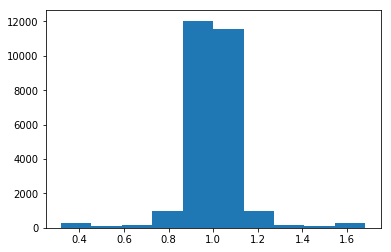

In [52]:
plt.hist(attns_arr)

In [54]:
turn_off_grad_except(['attn_weights'])
resnet_attn.eval() # Turn on batchnorm
_lambda = 1
train_one_epoch(add_attn=True)
score_top3()

[    1] iter, [0.000000] epoch, avg loss: 0.201, attn_loss: -0.22491 
[    6] iter, [0.019605] epoch, avg loss: 0.914, attn_loss: -1.13828 
[   11] iter, [0.039211] epoch, avg loss: 0.851, attn_loss: -1.16156 
[   16] iter, [0.058816] epoch, avg loss: 1.016, attn_loss: -1.18541 
[   21] iter, [0.078422] epoch, avg loss: 0.810, attn_loss: -1.20941 
[   26] iter, [0.098027] epoch, avg loss: 0.570, attn_loss: -1.23363 
[   31] iter, [0.117633] epoch, avg loss: 0.805, attn_loss: -1.25819 
[   36] iter, [0.137238] epoch, avg loss: 0.780, attn_loss: -1.28330 
[   41] iter, [0.156844] epoch, avg loss: 0.720, attn_loss: -1.30885 
[   46] iter, [0.176449] epoch, avg loss: 0.417, attn_loss: -1.33479 
[   51] iter, [0.196054] epoch, avg loss: 0.404, attn_loss: -1.36131 
[   56] iter, [0.215660] epoch, avg loss: 0.739, attn_loss: -1.38832 
[   61] iter, [0.235265] epoch, avg loss: 0.849, attn_loss: -1.41593 
[   66] iter, [0.254871] epoch, avg loss: 0.417, attn_loss: -1.44391 
[   71] iter, [0.274

100%|██████████| 55/55 [00:14<00:00,  3.93it/s]

0.61345496009122


In [17]:
#Training scheme
print_every = 50
val_accs = []
def train(seq = ['fc', 'att', 'fc', 'bn', 'att', 'att', 'bn', 'att', 'fc','att']):
    
    highest_acc1 = 0
    for idx, s in enumerate(seq):
        print('======================= epoch:', idx,'layer:',s"=========================")
        if s == 'fc':
            turn_off_grad_except(['fc'])
        elif s == 'att':
            turn_off_grad_except(['attn_weights'])
        elif s == 'bn':
            turn_off_grad_except(['bn'])
        training_acc,optimizer = train_one_epoch()
        
        correct_count1, correct_count3 = 0,0
        
        for inp, label in iter(valloader):
            _, idx1 = resnet_attn(Variable(inp).cuda()).topk(1)
            _, idx3 = resnet_attn(Variable(inp).cuda()).topk(3)
            
            lab = Variable(label).cuda()
            lab_expand1 = lab.unsqueeze(1).expand_as(idx1)
            lab_expand3 = lab.unsqueeze(1).expand_as(idx3)
            correct_count1 += int((idx1 == lab_expand1).sum())
            correct_count3 += int((idx3 == lab_expand3).sum())
            
        val_acc_1 = correct_count1/len(valset)
        val_acc_3 = correct_count3/len(valset)
        
        if val_acc_1 > highest_acc1:
            highest_acc1 = val_acc_1
            #Save best acc model state dict
            state = {
            'epoch': idx,
            'arch': seq,
            'state_dict': resnet_attn.state_dict(),
            'val_acc1': val_acc_1,
            'val_acc3': val_acc_3,
            'optimizer' : optimizer.state_dict()
            }
            save_checkpoint(state, 'epoch{}_val1_{}_val3_{}.pth'.format(idx, val_acc_1, val_acc_3), 'checkpoints/5-8/')
        print("top 1 val_acc: {} top 3 val_acc: {}".format(val_acc_1, val_acc_3))
        val_accs.append(val_acc_1)
    return highest_acc1, val_accs
    
def save_checkpoint(state, filename, cp_path):
    torch.save(state, os.path.join(cp_path, filename))
    print("saved model to {}".format(filename))

In [18]:
acc_t1, acc_t3, val_accs = train()

======================= epoch:  0 =========================
[    1] iter, [0.000000] epoch, avg loss: 0.100, attn_loss: 0.00000 
[   51] iter, [0.196054] epoch, avg loss: 4.456, attn_loss: 0.00000 
[  101] iter, [0.392109] epoch, avg loss: 3.804, attn_loss: 0.00000 
[  151] iter, [0.588163] epoch, avg loss: 3.496, attn_loss: 0.00000 
[  201] iter, [0.784218] epoch, avg loss: 3.344, attn_loss: 0.00000 
[  251] iter, [0.980272] epoch, avg loss: 3.189, attn_loss: 0.00000 
saved model to epoch0_val1_0.24629418472063855_val3_0.4258836944127708.pth
top 1 val_acc: 0.24629418472063855 top 3 val_acc: 0.4258836944127708
======================= epoch:  1 =========================
[    1] iter, [0.000000] epoch, avg loss: 0.059, attn_loss: 0.00000 
[   51] iter, [0.196054] epoch, avg loss: 2.995, attn_loss: -0.00002 
[  101] iter, [0.392109] epoch, avg loss: 2.799, attn_loss: -0.00005 
[  151] iter, [0.588163] epoch, avg loss: 2.712, attn_loss: -0.00009 
[  201] iter, [0.784218] epoch, avg loss: 2

NameError: name 'highest_acc_1' is not defined

In [10]:
checkpoint = torch.load('checkpoints/5-8/epoch9_val1_0.47263397947548463_val3_0.6835803876852907.pth')

In [13]:
resnet_attn.load_state_dict(checkpoint['state_dict'])
resnet_attn.cuda()
#test on best model
test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        normalize
    ])


testset = torchvision.datasets.ImageFolder(root=TEST_DIR, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
def test(model):
    model.eval()
    correct_count1, correct_count3 = 0, 0

    for inp, label in iter(testloader):
        _, idx1 = model(Variable(inp).cuda()).topk(1)
        _, idx3 = model(Variable(inp).cuda()).topk(3)

        lab = Variable(label).cuda()
        lab_expand1 = lab.unsqueeze(1).expand_as(idx1)
        lab_expand3 = lab.unsqueeze(1).expand_as(idx3)
        correct_count1 += int((idx1 == lab_expand1).sum())
        correct_count3 += int((idx3 == lab_expand3).sum())

    test_acc_1 = correct_count1/len(testset)
    test_acc_3 = correct_count3/len(testset)
    print("top 1 test acc:{}, top 3 test acc:{}".format(test_acc_1, test_acc_3))

In [14]:
test(resnet_attn)

top 1 test acc:0.4734010759115362, top 3 test acc:0.6826060968320382
